# Boosting the performance of python-code (without much pain)
## Profiling techniques, Numba and Cython

**Michiel Stock**: michielfmstock@gmail.com  
**Joris Van den Bossche**: joris.vandenbossche@ugent.be

## Motivation
In this tutorial we will try to improve the running time of a python implementation of the Viterbi algorithm, an important algorithm in bioinformatics and natural language processing. The Viterbi algorithm is a dynamic programming (DP) method that can, for a sequence of symbols and an associated Hidden Markov Model (HMM), find the most likely hidden states that could have genererated the symbols.

Why this example?
- easy to implement (ca. 20 lines of code)
- often need a specific version for a problem
- cannot be implemeted as mainly matrix manipulations (for loops required)
- polynomial time complexity => want to apply this to large datasets!

##Quick overview of Hidden Markov Models

A HMM is defined on a sequence of observed symbols $\mathbf{x}_1\ldots \mathbf{x}_t \ldots \mathbf{x}_T$. The basis idea is that each observed symbol $\mathbf{x}_t$ is determind stochastically by a discrete hidden state $\mathbf{z}_t$ by means of the following emission probability:

$$
\mathcal{P}(\mathbf{x}_t|\mathbf{z}_t)\,.
$$


Furthermore, the change in latent state is modelled by a first order Markov chain with known transition probabilities

$$
\mathcal{P}(\mathbf{z}_t|\mathbf{z}_{t-1})\,,
$$

in addition to a starting probablities:

$$
\mathcal{P}(\mathbf{z}_1)\,.
$$

So, given a sequence of symbols, the Viterbi algorithm finds the most probable sequence of hidden states, i.e.:

$$
\mathbf{z}_1^* \ldots \mathbf{z}_T^* = \text{argmax}_{\mathbf{z}_1\ldots \mathbf{z}_T}
\mathcal{P}(\mathbf{x}_t \ldots \mathbf{x}_T | \mathbf{z}_t \ldots \mathbf{z}_T)\,.
$$

![Alt text](HMMsequence.jpg "Example of a HMM")

##Running example

* We will start from a basic implementation written in Python and Numpy found in the file ``viterby.py``
* We will consider as simple HMM describing the **outcome of iteratively throwing a coin** from which we observe either **head (H) or tail (T)**. This sequence can be generated by  **fair (F) or a biased (B) coin**.
* We do not know which coin was used when, so we have to guess this with the viterbi algorithm!

## A simple implementation of the Viterbi algorithm

In [1]:
from viterbi import viterbi as viterbi_plain

In [2]:
symbols = ['H', 'T']
states = ['F', 'B']

emis_probs = np.array([[0.5, 0.1], [0.5, 0.9]])
trans_probs = np.array([[0.8, 0.2], [0.2, 0.8]])
starting_probs = np.array([0.99, 0.01])

In [3]:
symbols_to_int = lambda seq : np.array(map(lambda s : symbols.index(s), seq), dtype=int)
states_to_int = lambda seq : np.array(map(lambda s : states.index(s), seq), dtype=int)

int_to_symbols = lambda ints : ''.join(map(lambda i: symbols[i], ints))
int_to_states = lambda ints : ''.join(map(lambda i: states[i], ints))

In [4]:
sequence = 'HTHHTHHTTTHTTTTTTTTTHTTTHTTHTTHTHHHHTTTTTHHHTHHH'
symbols_to_int(sequence)

array([0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0])

In [5]:
print sequence
print int_to_states(viterbi_plain(symbols_to_int(sequence), emis_probs,
                                  trans_probs, starting_probs))

HTHHTHHTTTHTTTTTTTTTHTTTHTTHTTHTHHHHTTTTTHHHTHHH
FFFFFFFFBBBBBBBBBBBBBBBBBFFFFFFFFFFFFBBBBBFFFFFF


## Boosting performance

> *Premature optimization is the root of all evil.* ~Donald Knuth

1. Is it needed? -> **time**
2. What should I optimize -> **profile**
3. Leverage the numpy-stack
4. Use specific tools like cython or numba

##Small example of naive python code

In [6]:
def sum2d_naive(arr):
    """
    Sum of the elements of a matrix using for-loops
    """
    M, N = arr.shape
    result = 0.0
    for i in range(M):
        for j in range(N):
            result += arr[i,j]
    return result

## Timing your code: `%timeit`

In [7]:
import numpy as np
A = np.random.randn(500,500)

In [8]:
print sum2d_naive(A)
%timeit sum2d_naive(A)

-463.422835082
10 loops, best of 3: 85.1 ms per loop


In [9]:
print np.sum(A)
%timeit np.sum(A)

-463.422835082
10000 loops, best of 3: 199 µs per loop


##Pure python vs. Numpy

A numpy function is in this example approximately 500 times faster than a naively implemented python function. For this reason we try to use as many predefined functions from Numpy, Scipy, Pandas... as possible as these are usually written in a more performant language, such as C.

Sometimes we have to implement algorithms (sampling methods, inferrence algorithms, cellular automata...) that cannot be cast as only matrix manipulations but require some use of for loops... How do we improve the performance of our code for this?

## Back to our Viterbi algorithm: optimizing the basic code

## Timing the basic code

Let's use a small sequence to check how fast this function is.

In [10]:
symbols_int = symbols_to_int(sequence*10)  # make a bit longer for clearity
print symbols_int

[0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1
 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1
 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 1 1
 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0
 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1
 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1
 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1
 1 0 1 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1
 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1
 0 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 0 0
 0 0 1 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1
 1 0 1 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 0 0 0]


In [11]:
%timeit viterbi_plain(symbols_int, emis_probs, trans_probs, starting_probs)

10 loops, best of 3: 35.2 ms per loop


So this code takes about 30 ms (on my computer). If we want to use this on large datasets using more complex models it might be desirable to improve the code. Let us profile our code!

##Profiling the basic code

## Profile

A builtin way to profile code is using the `profile`/`cProfile` library, which is available through the `%prun` IPython magic:

In [12]:
prof0 = %prun -r viterbi_plain(symbols_int, emis_probs, trans_probs, starting_probs)
prof0.print_stats()

          11985 function calls in 0.042 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.016    0.016    0.042    0.042 viterbi.py:13(viterbi)
      958    0.010    0.000    0.010    0.000 {method 'reduce' of 'numpy.ufunc' objects}
      958    0.003    0.000    0.014    0.000 fromnumeric.py:2058(amax)
      959    0.003    0.000    0.011    0.000 fromnumeric.py:889(argmax)
      958    0.003    0.000    0.008    0.000 fromnumeric.py:40(_wrapit)
      959    0.002    0.000    0.002    0.000 {method 'argmax' of 'numpy.ndarray' objects}
      958    0.002    0.000    0.002    0.000 {numpy.core.multiarray.array}
        1    0.001    0.001    0.001    0.001 viterbi.py:44(backtracking)
      958    0.001    0.000    0.003    0.000 numeric.py:394(asarray)
     1438    0.001    0.000    0.001    0.000 {range}
      958    0.000    0.000    0.010    0.000 _methods.py:25(_amax)
     1916    0.000    0.000    0.000    

<pstats.Stats instance at 0x000000000BA58F08>

## The line profiler

To profile the code line by line, we can use the `line_profiler` (https://github.com/rkern/line_profiler):

In [13]:
%load_ext line_profiler

In [14]:
prof0 = %lprun -r -f viterbi_plain viterbi_plain(symbols_int, emis_probs, trans_probs, starting_probs)
prof0.print_stats()

 Timer unit: 4.1052e-07 s

File: viterbi.py
Function: viterbi at line 13
Total time: 0.0689016 s

Line #      Hits         Time  Per Hit   % Time  Line Contents
    13                                           def viterbi(seq_int, emission_probs, transition_probs,
    14                                                   starting_probs):
    15                                               '''
    16                                               Generates the dynamic programming matrix for a sequence of symbols
    17                                               INPUTS:
    18                                                   - seq_int: list of symbol indices
    19                                                   - emission_probs: emission_probabilities
    20                                                   - transition_probs: transition probabilities
    21                                                   - starting_probs: starting probabilities
    22                            

## Optimizing the basic code

## Optimizing the basic code

Things that take long:

- taking logarithms
- max and argmax

Changes (in file viterby_cleaned.py):

- l 35: log_probs initialized as np.array instead of list
- l 37: indexing np array instead of appending a list
- l 31, 38, 39: use log from math mode (numpy is optimized for arrays)
- l 40, 41: as we now have a np array, we also use max and argmax on arrays

Compare changes:

In [15]:
from viterbi_cleaned import viterbi as viterbi_cleaned

In [16]:
%timeit viterbi_cleaned(symbols_int, emis_probs, trans_probs, starting_probs)

100 loops, best of 3: 15.8 ms per loop


Ok, seems that we have cut the running time by more than half!

In [17]:
prof1 = %lprun -r -f viterbi_cleaned viterbi_cleaned(symbols_int, emis_probs, trans_probs, starting_probs)
prof1.print_stats()

 Timer unit: 4.1052e-07 s

File: viterbi_cleaned.py
Function: viterbi at line 14
Total time: 0.0338424 s

Line #      Hits         Time  Per Hit   % Time  Line Contents
    14                                           def viterbi(seq_int, emission_probs, transition_probs,
    15                                                   starting_probs):
    16                                               '''
    17                                               Generates the dynamic programming matrix for a sequence of symbols
    18                                               INPUTS:
    19                                                   - seq_int: list of symbol indices
    20                                                   - emission_probs: emission_probabilities
    21                                                   - transition_probs: transition probabilities
    22                                                   - starting_probs: starting probabilities
    23                    

## Numba

## Numba

Numba is a just-in-time Python compiler. With a few annotations, array-oriented and math-heavy Python code can be just-in-time compiled to native machine instructions, similar in performance to C, C++ and Fortran, without having to switch languages or Python interpreters.

Numba works by generating optimized machine code using the LLVM compiler infrastructure at import time, runtime, or statically (using the included pycc tool). Numba supports compilation of Python to run on either CPU or GPU hardware, and is designed to integrate with the Python scientific software stack.



For example, take our 2dsum:

In [18]:
import numba

@numba.jit  # that's it!
def sum2d_numba(arr):
    """
    Sum of the elements of a matrix using for-loops
    """
    M, N = arr.shape
    result = 0.0
    for i in range(M):
        for j in range(N):
            result += arr[i,j]
    return result

In [19]:
print sum2d_numba(A)
%timeit sum2d_numba(A)

-463.422835082
1000 loops, best of 3: 268 µs per loop


Numba is nearly as fast Numpy, while written using two nested for-loops!

## Using Numba on the Viterbi algorithm



Adding one `@jit` call to to main loop (separated into a function)

In [20]:
from viterbi_numba import viterbi as viterbi_numba

In [21]:
%timeit viterbi_numba(symbols_int, emis_probs, trans_probs, starting_probs)

The slowest run took 343.74 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 3: 906 µs per loop


An improvement of more than 100 times in terms of speed! 

But let's profile again.

In [22]:
prof2 = %lprun -r -f viterbi_numba viterbi_numba(symbols_int, emis_probs, trans_probs, starting_probs)
prof2.print_stats()

 Timer unit: 4.1052e-07 s

File: viterbi_numba.py
Function: viterbi at line 15
Total time: 0.00155792 s

Line #      Hits         Time  Per Hit   % Time  Line Contents
    15                                           def viterbi(seq_int, emission_probs, transition_probs,
    16                                                   starting_probs):
    17                                               '''
    18                                               Generates the dynamic programming matrix for a sequence of symbols
    19                                               INPUTS:
    20                                                   - seq_int: list of symbol indices
    21                                                   - emission_probs: emission_probabilities
    22                                                   - transition_probs: transition probabilities
    23                                                   - starting_probs: starting probabilities
    24                     

In [23]:
from viterbi_numba2 import viterbi as viterbi_numba2

In [24]:
%timeit viterbi_numba2(symbols_int, emis_probs, trans_probs, starting_probs)

The slowest run took 526.76 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 3: 891 µs per loop


Not much better? Let's look at the numba's annotations:

## Numba html annotation to inspect the optimizations

In [25]:
!numba --annotate-html annotate2.html viterbi_numba2.py

In [26]:
from IPython.display import HTML

In [27]:
HTML("annotate2.html")

39:,@jit
40:,"def fill_dyn_prog_matrix(seq_int, emission_probs, transition_probs,\"
41:,"starting_probs, dyn_prog_matrix, pointers, n_states):"
42:,log_probs = np.zeros(n_states)
,label 0
,"seq_int = arg(0, name=seq_int) :: pyobject"
,"emission_probs = arg(1, name=emission_probs) :: pyobject"
,"transition_probs = arg(2, name=transition_probs) :: pyobject"
,"starting_probs = arg(3, name=starting_probs) :: pyobject"
,del starting_probs
,"dyn_prog_matrix = arg(4, name=dyn_prog_matrix) :: pyobject"


In [28]:
from viterbi_numba3 import viterbi as viterbi_numba3

In [29]:
%timeit viterbi_numba3(symbols_int, emis_probs, trans_probs, starting_probs)

The slowest run took 5633.13 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 3: 86.6 µs per loop


Much better! Again a factor 10 improvement

In [30]:
prof2 = %lprun -r -f viterbi_numba3 viterbi_numba3(symbols_int, emis_probs, trans_probs, starting_probs)
prof2.print_stats()

 Timer unit: 4.1052e-07 s

File: viterbi_numba3.py
Function: viterbi at line 15
Total time: 0.000261501 s

Line #      Hits         Time  Per Hit   % Time  Line Contents
    15                                           def viterbi(seq_int, emission_probs, transition_probs,
    16                                                   starting_probs):
    17                                               '''
    18                                               Generates the dynamic programming matrix for a sequence of symbols
    19                                               INPUTS:
    20                                                   - seq_int: list of symbol indices
    21                                                   - emission_probs: emission_probabilities
    22                                                   - transition_probs: transition probabilities
    23                                                   - starting_probs: starting probabilities
    24                   

In [31]:
!numba --annotate-html annotate3.html viterbi_numba3.py

In [32]:
HTML("annotate3.html")

39:,@jit
40:,"def fill_dyn_prog_matrix(seq_int, emission_probs, transition_probs,\"
41:,"starting_probs, dyn_prog_matrix, pointers, n_states):"
42:,log_probs = np.zeros(n_states)
,label 0
,"seq_int = arg(0, name=seq_int) :: pyobject"
,"emission_probs = arg(1, name=emission_probs) :: pyobject"
,"transition_probs = arg(2, name=transition_probs) :: pyobject"
,"starting_probs = arg(3, name=starting_probs) :: pyobject"
,del starting_probs
,"dyn_prog_matrix = arg(4, name=dyn_prog_matrix) :: pyobject"


In [33]:
from viterbi_numba4 import viterbi as viterbi_numba4

In [34]:
!numba --annotate-html annotate4.html viterbi_numba4.py

In [35]:
HTML("annotate4.html")

40:,@jit
41:,"def fill_dyn_prog_matrix(seq_int, emission_probs, transition_probs,\"
42:,"starting_probs, dyn_prog_matrix, pointers, n_states):"
43:,log_probs = np.zeros(n_states)
,label 0
,"seq_int = arg(0, name=seq_int) :: pyobject"
,"emission_probs = arg(1, name=emission_probs) :: pyobject"
,"transition_probs = arg(2, name=transition_probs) :: pyobject"
,"starting_probs = arg(3, name=starting_probs) :: pyobject"
,del starting_probs
,"dyn_prog_matrix = arg(4, name=dyn_prog_matrix) :: pyobject"


In [36]:
%timeit viterbi_numba4(symbols_int, emis_probs, trans_probs, starting_probs)

The slowest run took 4534.01 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 3: 79.6 µs per loop


In [37]:
prof2 = %lprun -r -f viterbi_numba4 viterbi_numba4(symbols_int, emis_probs, trans_probs, starting_probs)
prof2.print_stats()

 Timer unit: 4.1052e-07 s

File: viterbi_numba4.py
Function: viterbi at line 15
Total time: 0.000128082 s

Line #      Hits         Time  Per Hit   % Time  Line Contents
    15                                           def viterbi(seq_int, emission_probs, transition_probs,
    16                                                   starting_probs):
    17                                               '''
    18                                               Generates the dynamic programming matrix for a sequence of symbols
    19                                               INPUTS:
    20                                                   - seq_int: list of symbol indices
    21                                                   - emission_probs: emission_probabilities
    22                                                   - transition_probs: transition probabilities
    23                                                   - starting_probs: starting probabilities
    24                   

Finally, also jitting the main function gives some more improvement:

In [38]:
viterbi_numba = numba.jit(viterbi_numba4)

In [39]:
%timeit viterbi_numba(symbols_int, emis_probs, trans_probs, starting_probs)

The slowest run took 2336.81 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 3: 135 µs per loop


## Cython

Cython is a compiled language that generates CPython extension modules. The main idea is to save your python script as a .pyx file and add a few annotations to aid the compilation. Using a setup.py file this code can be converted to C code and the functions can be imported from a main Python program.

Using %Cython magic, some of the work can be automated, so that your Cython functions only have to be written in a specific cell. The C based function will be available during the remainder of the session.

IPython provides a function to translate python code in C code using the Cython magic function. For this we have to add explicit type declarations.

In [40]:
%load_ext Cython

In [41]:
%%cython

cimport cython
import numpy as np
cimport numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)  # Cython will neither check for nor correctly handle negative indices
def sum2d_cython(double[:, ::1] arr):
    """
    Sum of the elements of a matrix
    using for-loops
    """
    cdef int M, N, i, j
    cdef double result
    M = arr.shape[0]
    N = arr.shape[1]
    result = 0.0
    for i in range(M):
        for j in range(N):
            result += arr[i,j]
    return result

In [42]:
print sum2d_cython(A)
%timeit sum2d_cython(A)

-463.422835082
1000 loops, best of 3: 291 µs per loop


We get almost the same speedup as with Numba, but with a bit more work.

Let's try on our Viterbi algorithm!

In [43]:
%%cython

import numpy as np
from math import log

def viterbi_cython(seq_int, emission_probs, transition_probs,
                   starting_probs):
    '''
    Generates the dynamic programming matrix for a sequence of symbols
    '''
    n_states = transition_probs.shape[0]
    length_seq = len(seq_int)
    dyn_prog_matrix = np.zeros((n_states, length_seq))
    pointers = np.zeros((n_states, length_seq), dtype=int)
    # initialise the matrix
    for i in range(n_states):
        # log of prob starting at this position given first symbol
        dyn_prog_matrix[i, 0] = log(starting_probs[i]) +\
                log(emission_probs[seq_int[0], i])
    # now fill the rest
    log_probs = np.zeros(n_states)
    for i, symb in enumerate(seq_int[1:]):
        for state in range(n_states):
            for prev_state in range(n_states):
                log_probs[prev_state] = ( dyn_prog_matrix[prev_state, i] +\
                    log(transition_probs[prev_state, state]) +\
                    log(emission_probs[symb, state]))
            dyn_prog_matrix[state, i+1] = np.max(log_probs)
            pointers[state, i+1] = np.argmax(log_probs)
    return backtracking(dyn_prog_matrix, pointers)

def backtracking(dyn_prog_matrix, pointers):
    '''
    Uses backtracking to find the best sequence
    '''
    pos = dyn_prog_matrix.shape[1] - 1
    seq = np.zeros( dyn_prog_matrix.shape[1], dtype = int )
    pointy_finger = np.argmax(dyn_prog_matrix[:, -1])
    seq[pos] = pointy_finger
    while pos >= 1:
        pos -= 1
        pointy_finger = pointers[pointy_finger, pos]
        seq[pos] = pointy_finger
    return seq

In [44]:
%timeit viterbi_cython(symbols_int, emis_probs, trans_probs, starting_probs)

100 loops, best of 3: 11.8 ms per loop


Only compiling it with cython does not yield much performance improvements. To let the compiled version run faster, we have to add type declarations:

In [45]:
%%cython
cimport cython
import numpy as np

cimport numpy as np
from libc.math cimport log

#@cython.profile
@cython.boundscheck(False)
@cython.wraparound(False)
def viterbi_cython(long[::1] seq_int,
                   double[:, ::1] emission_probs, 
                   double[:, ::1] transition_probs,
                   double[::1] starting_probs):
    '''
    Generates the dynamic programming matrix for a sequence of symbols
    INPUTS:
        - seq_int: list of symbol indices
        - emission_probs: emission_probabilities
        - transition_probs: transition probabilities
        - starting_probs: starting probabilities
    '''
    # define as C-variables
    cdef int n_states = transition_probs.shape[0]
    cdef int length_seq = seq_int.shape[0]
    cdef int i, state, prev_state
    cdef int symb
    cdef double[:, ::1] dyn_prog_matrix = np.zeros((n_states, length_seq))
    cdef long[:, ::1] pointers = np.zeros((n_states, length_seq), dtype=np.int)
    
    # initialise the matrix
    for i in range(n_states):
        # log of prob starting at this position given first symbol
        dyn_prog_matrix[i, 0] = log(starting_probs[i]) +\
                log(emission_probs[seq_int[0], i])
    # now fill the rest
    log_probs = np.zeros(n_states)
    cdef double[::1] log_probs_v = log_probs
    for i in range(length_seq-1):
        symb = seq_int[i+1]
        for state in range(n_states):
            for prev_state in range(n_states):
                log_probs_v[prev_state] = ( dyn_prog_matrix[prev_state, i] +\
                    log(transition_probs[prev_state, state]) +\
                    log(emission_probs[symb, state]))
            dyn_prog_matrix[state, i+1] = np.max(log_probs)
            pointers[state, i+1] = np.argmax(log_probs)
    return backtracking_cython(dyn_prog_matrix, pointers)

@cython.boundscheck(False)
@cython.wraparound(False)
def backtracking_cython(double[:, ::1] dyn_prog_matrix,
                        long[:, ::1] pointers):
    '''
    Uses backtracking to find the best sequence
    '''
    cdef int pos = dyn_prog_matrix.shape[1] - 1
    cdef int pointy_finger = np.argmax(dyn_prog_matrix[:, -1])
    cdef int[::1] seq = np.zeros( dyn_prog_matrix.shape[1], dtype=np.int)
    seq[pos] = pointy_finger
    while pos >= 1:
        pos -= 1
        pointy_finger = pointers[pointy_finger, pos]
        seq[pos] = pointy_finger
    return seq

In [46]:
%timeit viterbi_cython(symbols_int, emis_probs, trans_probs, starting_probs)

100 loops, best of 3: 6.44 ms per loop


This only improved it for ca 50% (and not as fast as numba). Let's see what is going to investigate if this can be improved.

For this, we can use profiling and annotating (`%cython -a`)

In [47]:
pprof1 = %prun -r viterbi_cython(np.tile(symbols_int, 1000), emis_probs, trans_probs, starting_probs)
pprof1.print_stats()

          4800007 function calls in 8.053 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   959998    3.793    0.000    3.793    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        1    1.384    1.384    8.053    8.053 {_cython_magic_524d839465c25efc30c1750c998b8049.viterbi_cython}
   959999    1.109    0.000    1.109    0.000 {method 'argmax' of 'numpy.ndarray' objects}
   959998    0.878    0.000    5.043    0.000 fromnumeric.py:2058(amax)
   959999    0.516    0.000    1.625    0.000 fromnumeric.py:889(argmax)
   959998    0.372    0.000    4.166    0.000 _methods.py:25(_amax)
        1    0.001    0.001    0.001    0.001 {method 'repeat' of 'numpy.ndarray' objects}
        1    0.000    0.000    8.053    8.053 <string>:1(<module>)
        1    0.000    0.000    0.001    0.001 shape_base.py:792(tile)
        2    0.000    0.000    0.000    0.000 {method 'reshape' of 'numpy.ndarray' objects}
        1    0.000    0.

<pstats.Stats instance at 0x000000000DB72388>

It seems that the culprit is mainly the calls to `max`/`argmax`. This are still python function calls, creating overhead.

Let's implement them ourselves.

In [48]:
%%cython
cimport cython
import numpy as np

cimport numpy as np
from libc.math cimport log

#@cython.profile
@cython.boundscheck(False)
@cython.wraparound(False)
def viterbi_cython2(long[::1] seq_int,
                   double[:, ::1] emission_probs, 
                   double[:, ::1] transition_probs,
                   double[::1] starting_probs):
    '''
    Generates the dynamic programming matrix for a sequence of symbols
    INPUTS:
        - seq_int: list of symbol indices
        - emission_probs: emission_probabilities
        - transition_probs: transition probabilities
        - starting_probs: starting probabilities
    '''
    # define as C-variables
    cdef int n_states = transition_probs.shape[0]
    cdef int length_seq = seq_int.shape[0]
    cdef int i, state, prev_state
    cdef int symb
    cdef double[:, ::1] dyn_prog_matrix = np.zeros((n_states, length_seq))
    cdef long[:, ::1] pointers = np.zeros((n_states, length_seq), dtype=np.int)
    
    # initialise the matrix
    for i in range(n_states):
        # log of prob starting at this position given first symbol
        dyn_prog_matrix[i, 0] = log(starting_probs[i]) +\
                log(emission_probs[seq_int[0], i])
    # now fill the rest
    cdef double[::1] log_probs_v = np.zeros(n_states)
    for i in range(length_seq-1):
        symb = seq_int[i+1]
        for state in range(n_states):
            for prev_state in range(n_states):
                log_probs_v[prev_state] = ( dyn_prog_matrix[prev_state, i] +\
                    log(transition_probs[prev_state, state]) +\
                    log(emission_probs[symb, state]))
            dyn_prog_matrix[state, i+1] = maxx(log_probs_v)
            pointers[state, i+1] = argmaxx(log_probs_v)
    return backtracking_cython2(dyn_prog_matrix, pointers)

@cython.boundscheck(False)
@cython.wraparound(False)
cdef int argmaxx(double[::1] a):
    cdef int l = a.shape[0]
    cdef double m = maxx(a)
    cdef int i
    
    for i in range(l):
        if a[i] == m:
            break

    return i

@cython.boundscheck(False)
@cython.wraparound(False)
cdef double maxx(double[::1] a):
    cdef int l = a.shape[0]
    cdef double m = a[0]
    cdef int i

    for i in range(1, l):
        if a[i] > m:
            m = a[i]

    return m

@cython.boundscheck(False)
@cython.wraparound(False)
def backtracking_cython2(double[:, ::1] dyn_prog_matrix,
                        long[:, ::1] pointers):
    '''
    Uses backtracking to find the best sequence
    '''
    cdef int pos = dyn_prog_matrix.shape[1] - 1
    cdef int pointy_finger = np.argmax(dyn_prog_matrix[:, -1])
    cdef int[::1] seq = np.zeros( dyn_prog_matrix.shape[1], dtype=np.int)
    seq[pos] = pointy_finger
    while pos >= 1:
        pos -= 1
        pointy_finger = pointers[pointy_finger, pos]
        seq[pos] = pointy_finger
    return seq

In [49]:
%timeit viterbi_cython2(symbols_int, emis_probs, trans_probs, starting_probs)

10000 loops, best of 3: 184 µs per loop


That is looking better!

## Comparison of the different approaches

Let us do a comparision in time complexity for the different approaches.

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import random

In [51]:
length_seqs = [4**i for i in range(1, 9)]
perf_plain = []
perf_cleaned = []
perf_numba = []
perf_cython = []
perf_cython2 = []

In [52]:
for length in length_seqs:
    seq_symbols = [random.choice(['H', 'T']) for i in range(length)]
    seq_ints = symbols_to_int(seq_symbols)
    time_plain = %timeit -o -q viterbi_plain(seq_ints, emis_probs, trans_probs, starting_probs)
    time_cleaned = %timeit -o -q viterbi_cleaned(seq_ints, emis_probs, trans_probs, starting_probs)
    time_numba = %timeit -o -q viterbi_numba(seq_ints, emis_probs, trans_probs, starting_probs)
    time_cython = %timeit -o -q viterbi_cython(seq_ints, emis_probs, trans_probs, starting_probs)
    time_cython2 = %timeit -o -q viterbi_cython2(seq_ints, emis_probs, trans_probs, starting_probs)
    
    perf_plain.append(time_plain.best)
    perf_cleaned.append(time_cleaned.best)
    perf_numba.append(time_numba.best)
    perf_cython.append(time_cython.best)
    perf_cython2.append(time_cython2.best)

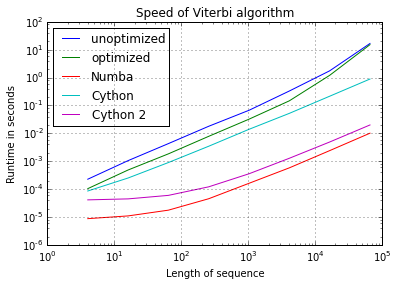

In [53]:
fig, ax = plt.subplots()
ax.grid()
ax.loglog()
ax.set_title('Speed of Viterbi algorithm')
ax.set_xlabel('Length of sequence')
ax.set_ylabel('Runtime in seconds')

plt.plot(length_seqs, perf_plain, label='unoptimized')
plt.plot(length_seqs, perf_cleaned, label='optimized')
plt.plot(length_seqs, perf_numba, label='Numba')
plt.plot(length_seqs, perf_cython, label='Cython')
plt.plot(length_seqs, perf_cython2, label='Cython 2')
plt.legend(loc=0)
plt.savefig('performance_viterbi.pdf')

##Conclusions (for this small case study)

- use lineprofiler to check for slow parts in the code
- **always** try to predefine numpy arrays, try to avoid list manipulations
- using numba is trivial, at least if your code follows the above rule!
- Cython is slightly more involved, but also (at this moment) more powerful and flexible (supports full of python)
- Numba has appearantly higher overhead, seems to really shine for large data (which is good!)